In [1]:
from IPython.core.display import display, HTML, Javascript

color_map = ['#cb013a', '#fe6792', '#fe80a4','#fe80a4', '#fe80a4','#ffe6ed']


prompt = color_map[-1]
main_color = color_map[0]
strong_main_color = color_map[1]
custom_colors = [strong_main_color, main_color]

css_file = ''' 

div #notebook {
background-color: white;
line-height: 20px;
}

#notebook-container {
%s
margin-top: 2em;
padding-top: 2em;
border-top: 4px solid %s; /* light orange */
-webkit-box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
    box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
}

div .input {
margin-bottom: 1em;
}

.rendered_html h1, .rendered_html h2, .rendered_html h3, .rendered_html h4, .rendered_html h5, .rendered_html h6 {
color: %s; /* light orange */
font-weight: 600;
}

div.input_area {
border: none;
    background-color: %s; /* rgba(229, 143, 101, 0.1); light orange [exactly #E58F65] */
    border-top: 2px solid %s; /* light orange */
}

div.input_prompt {
color: %s; /* light blue */
}

div.output_prompt {
color: %s; /* strong orange */
}

div.cell.selected:before, div.cell.selected.jupyter-soft-selected:before {
background: %s; /* light orange */
}

div.cell.selected, div.cell.selected.jupyter-soft-selected {
    border-color: %s; /* light orange */
}

.edit_mode div.cell.selected:before {
background: %s; /* light orange */
}

.edit_mode div.cell.selected {
border-color: %s; /* light orange */

}
'''
def to_rgb(h): 
    return tuple(int(h[i:i+2], 16) for i in [0, 2, 4])

main_color_rgba = 'rgba(%s, %s, %s, 0.1)' % (to_rgb(main_color[1:]))
open('notebook.css', 'w').write(css_file % ('width: 95%;', main_color, main_color, main_color_rgba, main_color,  main_color, prompt, main_color, main_color, main_color, main_color))

def nb(): 
    return HTML("<style>" + open("notebook.css", "r").read() + "</style>")
nb()

In [3]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve ,KFold
from sklearn.metrics import roc_curve,accuracy_score,f1_score,auc,confusion_matrix,roc_auc_score
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
df=pd.read_csv("winequality-red.csv")
df.head().style.background_gradient(cmap='cool')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.400000,0.700000,0.000000,1.900000,0.076000,11.000000,34.000000,0.997800,3.510000,0.560000,9.400000,5
1,7.800000,0.880000,0.000000,2.600000,0.098000,25.000000,67.000000,0.996800,3.200000,0.680000,9.800000,5
2,7.800000,0.760000,0.040000,2.300000,0.092000,15.000000,54.000000,0.997000,3.260000,0.650000,9.800000,5
3,11.200000,0.280000,0.560000,1.900000,0.075000,17.000000,60.000000,0.998000,3.160000,0.580000,9.800000,6
4,7.400000,0.700000,0.000000,1.900000,0.076000,11.000000,34.000000,0.997800,3.510000,0.560000,9.400000,5


In [6]:
df1=df.copy()

In [7]:
df.shape

(1599, 12)

In [8]:
numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
print('Number of numerical variables: ', len(numerical_features))
print('-'*100)
print('Numerical Variables Column: ',numerical_features)

Number of numerical variables:  12
----------------------------------------------------------------------------------------------------
Numerical Variables Column:  ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


In [9]:
df.ndim

2

In [10]:
df.index

RangeIndex(start=0, stop=1599, step=1)

In [11]:
df.size

19188

In [12]:
def memory_use():
    print('\033[1m'+'Memory used by all colomns in bytes'+'\033[0m')

In [13]:
k = df.memory_usage()
print(k,'bytes'+'\n')

Index                     128
fixed acidity           12792
volatile acidity        12792
citric acid             12792
residual sugar          12792
chlorides               12792
free sulfur dioxide     12792
total sulfur dioxide    12792
density                 12792
pH                      12792
sulphates               12792
alcohol                 12792
quality                 12792
dtype: int64 bytes



In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [15]:
memory_usage = df.memory_usage(deep=True) / 1024 ** 2
print('memory usage of features: \n', memory_usage.head(7))
print('memory usage sum: ',memory_usage.sum())

memory usage of features: 
 Index                  0.000122
fixed acidity          0.012199
volatile acidity       0.012199
citric acid            0.012199
residual sugar         0.012199
chlorides              0.012199
free sulfur dioxide    0.012199
dtype: float64
memory usage sum:  0.146514892578125


In [16]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

df = reduce_memory_usage(df, verbose=True)

Mem. usage decreased to 0.04 Mb (76.0% reduction)


In [17]:
from IPython.core.display import HTML
def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>')

In [18]:
df_nunique = {var: pd.DataFrame(df[var].value_counts()) 
              for var in {'quality'}}
multi_table([df_nunique['quality'].style.background_gradient(cmap='cool')])

,quality
5,681
6,638
7,199
4,53
8,18
3,10


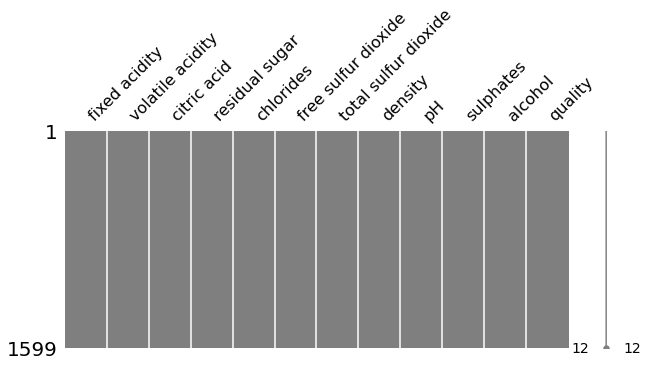

In [19]:
import missingno as mn
mn.matrix(df,color=(0.5,0.5,0.5),figsize = (10,4))

In [20]:
df.duplicated().sum()

240

In [21]:
df.drop_duplicates(inplace=True)

In [22]:
round(df.describe(exclude = 'object'), 2).T.style.background_gradient(cmap='cool')

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1359.000000,8.310000,1.740000,4.600000,7.100000,7.900000,9.200000,15.900000
volatile acidity,1359.000000,0.530000,0.180000,0.120000,0.390000,0.520000,0.640000,1.580000
citric acid,1359.000000,0.270000,0.200000,0.000000,0.090000,0.260000,0.430000,1.000000
residual sugar,1359.000000,2.520000,1.350000,0.900000,1.900000,2.200000,2.600000,15.500000
chlorides,1359.000000,0.090000,0.050000,0.010000,0.070000,0.080000,0.090000,0.610000
free sulfur dioxide,1359.000000,15.890000,10.450000,1.000000,7.000000,14.000000,21.000000,72.000000
total sulfur dioxide,1359.000000,46.840000,33.410000,6.000000,22.000000,38.000000,63.000000,289.000000
density,1359.000000,1.000000,0.000000,0.990000,1.000000,1.000000,1.000000,1.000000
pH,1359.000000,3.310000,0.160000,2.740000,3.210000,3.310000,3.400000,4.010000
sulphates,1359.000000,0.660000,0.170000,0.330000,0.550000,0.620000,0.730000,2.000000


Text(0.5, 0.98, 'Distribution Of The Fixed Acidity Before Treating Oultier')

(-0.5, 5.5, 4.03671875, 16.46328125)

(2.682623504969573, 17.817376495030427, 0.0, 0.35495955959806874)

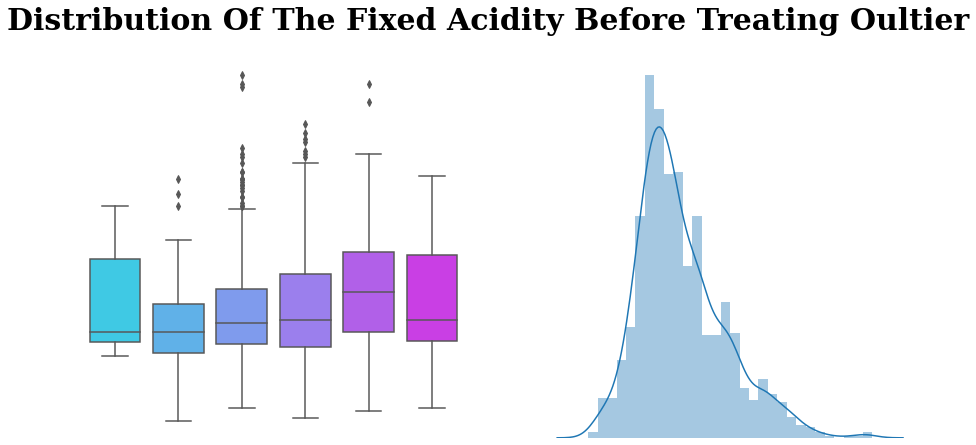

In [23]:
plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('Distribution Of The Fixed Acidity Before Treating Oultier', fontsize=30, fontweight='bold')

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x=df["quality"], y=df["fixed acidity"],palette="cool")
plt.axis('off')

ax2 = fig.add_subplot(122)
x=df["fixed acidity"]
ax2 = sns.distplot(x)
plt.axis('off')
plt.show()

Text(0.5, 0.98, 'Distribution Of The Fixed Acidity After Treating Outlier')

(-0.5, 5.5, 1.464404296875, 2.827587890625)

(1.308548454429566, 2.983443733070434, 0.0, 2.6428443943450284)

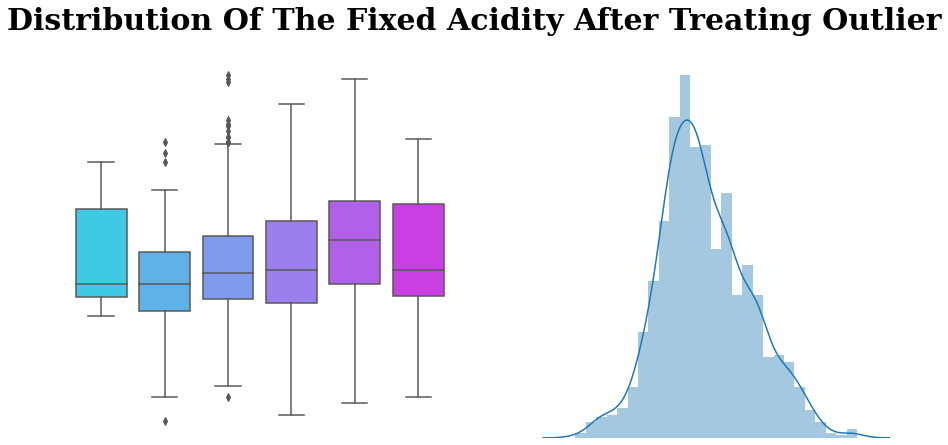

In [24]:
df["Log_fixed acidity"]=np.log(df["fixed acidity"])

plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('Distribution Of The Fixed Acidity After Treating Outlier', fontsize=30, fontweight='bold')

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x=df["quality"], y=df["Log_fixed acidity"],palette="cool")
plt.axis('off')

ax2 = fig.add_subplot(122)
x=df["Log_fixed acidity"]
ax2 = sns.distplot(x)
plt.axis('off')
plt.show()

Text(0.5, 0.98, 'Distribution Of The Volatile Acidity Before Treating Oultier')

(-0.5, 5.5, 0.04699096679687499, 1.653082275390625)

(-0.09569428140088183, 1.7957675235883819, 0.0, 2.357436503072067)

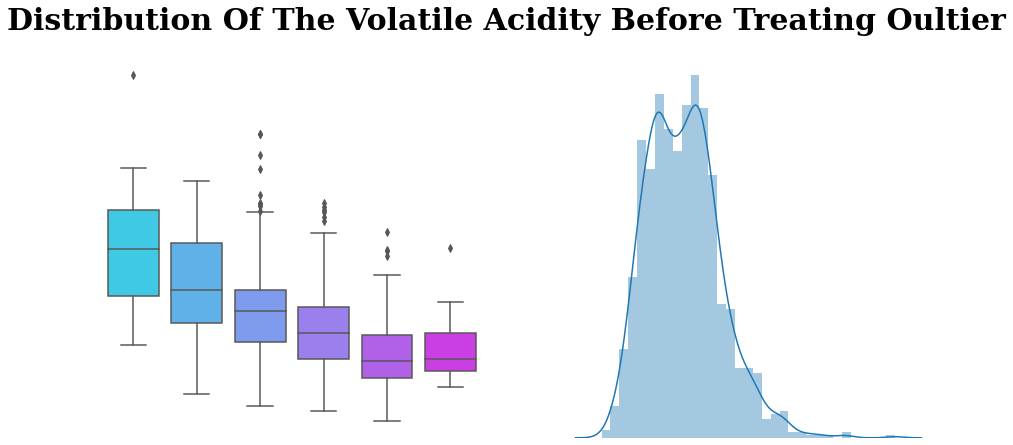

In [25]:
plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('Distribution Of The Volatile Acidity Before Treating Oultier', fontsize=30, fontweight='bold')

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x=df["quality"], y=df["volatile acidity"],palette="cool")
plt.axis('off')

ax2 = fig.add_subplot(122)
x=df["volatile acidity"]
ax2 = sns.distplot(x)
plt.axis('off')
plt.show()

Text(0.5, 0.98, 'Distribution Of The Volatitle After Treating Outliers')

(-0.5, 5.5, -2.2500244140625, 0.5864501953125)

(-2.527377872441764, 0.8638036536917642, 0.0, 1.303385496676203)

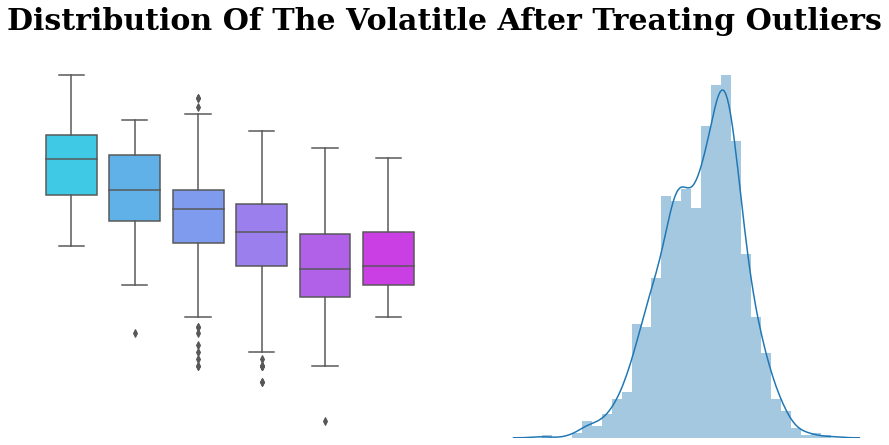

In [26]:
df["Log_volatile acidity"]=np.log(df["volatile acidity"])

plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('Distribution Of The Volatitle After Treating Outliers', fontsize=30, fontweight='bold')

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x=df["quality"], y=df["Log_volatile acidity"],palette="cool")
plt.axis('off')

ax2 = fig.add_subplot(122)
x=df["Log_volatile acidity"]
ax2 = sns.distplot(x)
plt.axis('off')
plt.show()

Text(0.5, 0.98, 'Distribution Of The Citric Acidity')

(-0.5, 5.5, -0.05, 1.05)

(-0.20243413835973134, 1.2024341383597312, 0.0, 3.244260485651214)

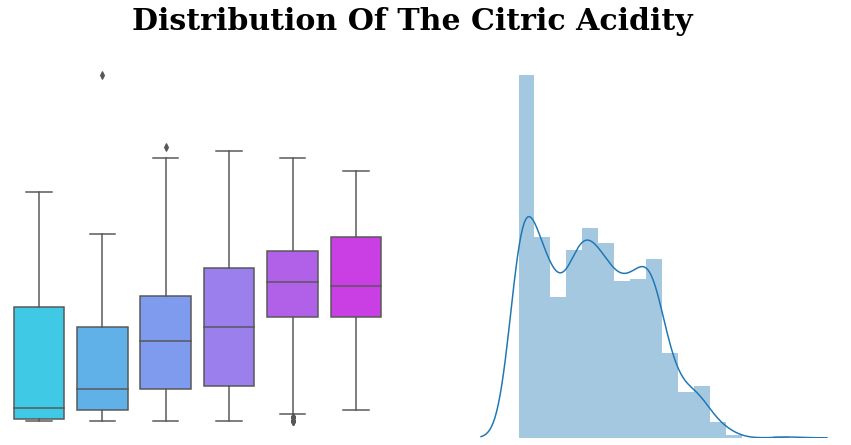

In [27]:
plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('Distribution Of The Citric Acidity', fontsize=30, fontweight='bold')

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x=df["quality"], y=df["citric acid"],palette="cool")
plt.axis('off')

ax2 = fig.add_subplot(122)
x=df["citric acid"]
ax2 = sns.distplot(x)
plt.axis('off')
plt.show()

Text(0.5, 0.98, 'Distribution Of The Residual Sugar Before Treating Oultier')

(-0.5, 5.5, 0.1698974609374999, 16.2300048828125)

(-0.884328351729005, 17.284230695479003, 0.0, 0.8969821160381135)

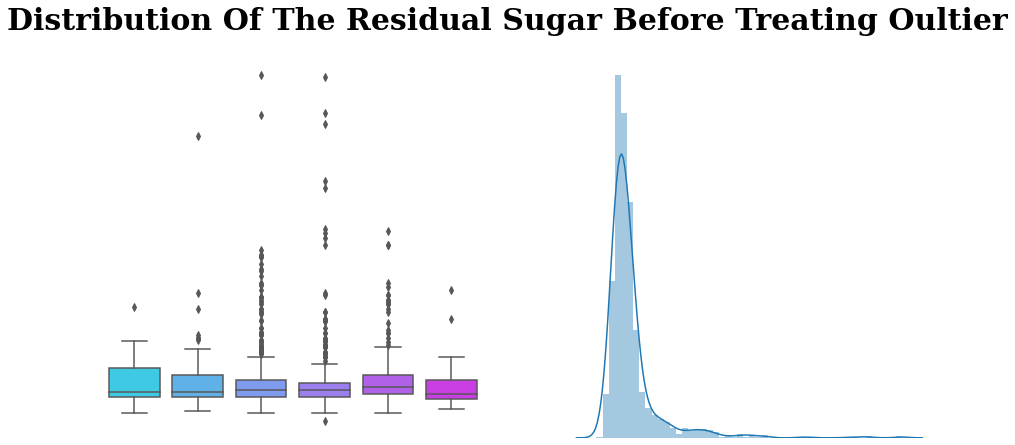

In [28]:
plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('Distribution Of The Residual Sugar Before Treating Oultier', fontsize=30, fontweight='bold')

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x=df["quality"], y=df["residual sugar"],palette="cool")
plt.axis('off')

ax2 = fig.add_subplot(122)
x=df["residual sugar"]
ax2 = sns.distplot(x)
plt.axis('off')
plt.show()

Text(0.5, 0.98, 'Distribution Of The Residual Sugar After Treating Outliers')

(-0.5, 5.5, -0.24775390625000002, 2.88251953125)

(-0.5206186809548139, 3.155384305954814, 0.0, 3.2309275007916427)

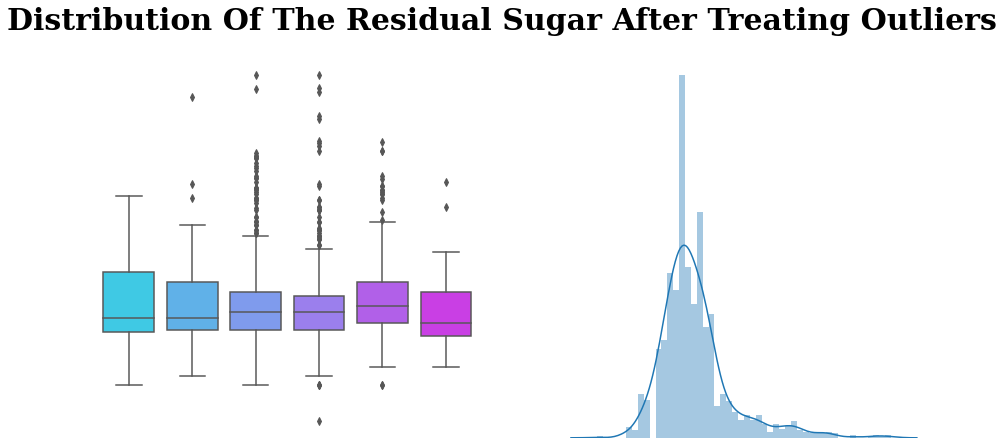

In [29]:
df["Log_residual sugar"]=np.log(df["residual sugar"])

plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('Distribution Of The Residual Sugar After Treating Outliers', fontsize=30, fontweight='bold')

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x=df["quality"], y=df["Log_residual sugar"],palette="cool")
plt.axis('off')

ax2 = fig.add_subplot(122)
x=df["Log_residual sugar"]
ax2 = sns.distplot(x)
plt.axis('off')
plt.show()

Text(0.5, 0.98, 'Distribution Of The Chlorides Before Treating Oultier')

(-0.5, 5.5, -0.01794090270996094, 0.6407817840576172)

(-0.05643435933832553, 0.6792752406859818, 0.0, 28.513608357061088)

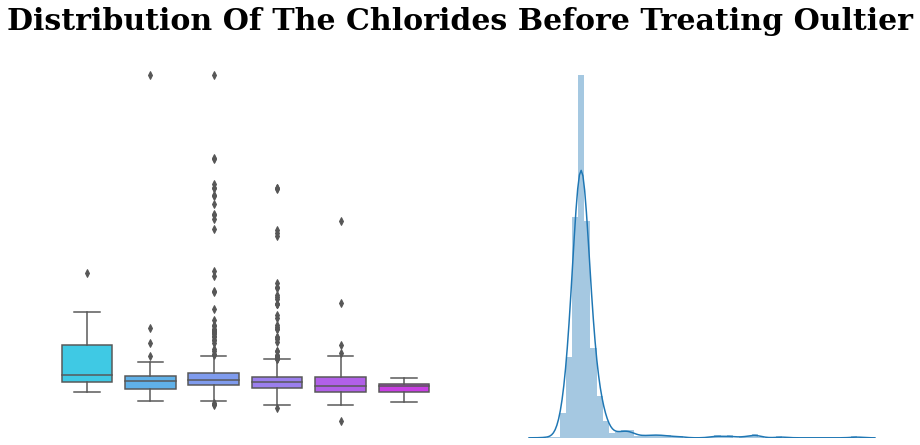

In [30]:
plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('Distribution Of The Chlorides Before Treating Oultier', fontsize=30, fontweight='bold')

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x=df["quality"], y=df["chlorides"],palette="cool")
plt.axis('off')

ax2 = fig.add_subplot(122)
x=df["chlorides"]
ax2 = sns.distplot(x)
plt.axis('off')
plt.show()

Text(0.5, 0.98, 'Distribution Of The Chlorides After Treating Outliers')

(-0.5, 5.5, -4.61832275390625, -0.29647216796875)

(-4.880298926384676, -0.03449599549032362, 0.0, 2.3401286863373842)

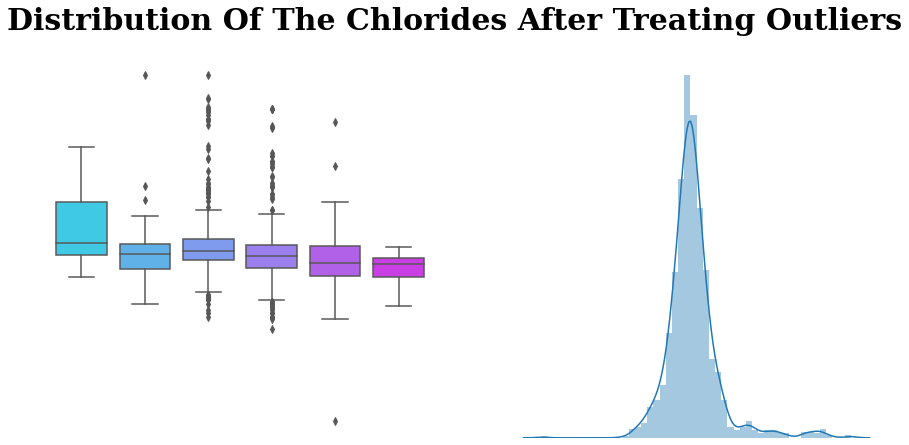

In [31]:
df["Log_chlorides"]=np.log(df["chlorides"])

plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('Distribution Of The Chlorides After Treating Outliers', fontsize=30, fontweight='bold')

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x=df["quality"], y=df["Log_chlorides"],palette="cool")
plt.axis('off')

ax2 = fig.add_subplot(122)
x=df["Log_chlorides"]
ax2 = sns.distplot(x)
plt.axis('off')
plt.show()

Text(0.5, 0.98, 'Distribution Of The Free Sulfurdioxide Before Treating Oultier')

(-0.5, 5.5, -2.5500000000000003, 75.55)

(-10.694658476278263, 83.69465847627826, 0.0, 0.07226782327519196)

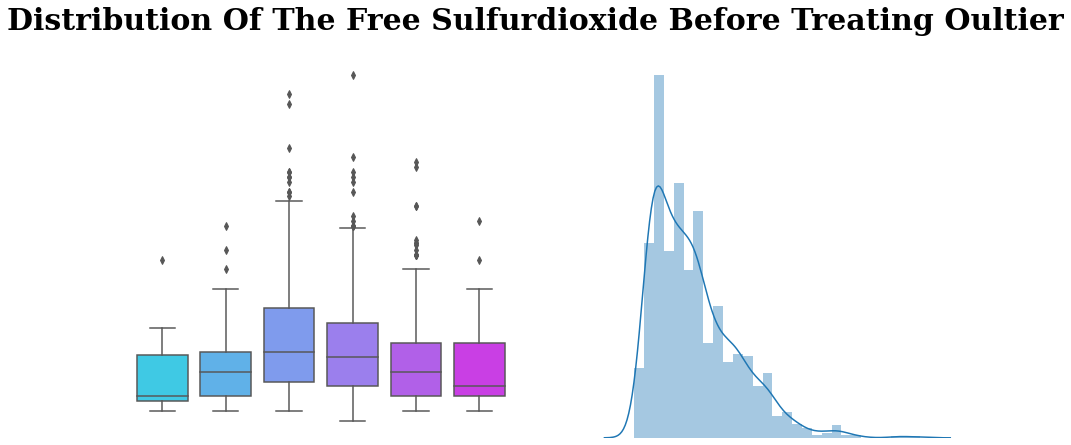

In [32]:
plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('Distribution Of The Free Sulfurdioxide Before Treating Oultier', fontsize=30, fontweight='bold')

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x=df["quality"], y=df["free sulfur dioxide"],palette="cool")
plt.axis('off')

ax2 = fig.add_subplot(122)
x=df["free sulfur dioxide"]
ax2 = sns.distplot(x)
plt.axis('off')
plt.show()

Text(0.5, 0.98, 'Distribution Of The Free Sulfurdioxide After Treating Outliers')

(-0.5, 5.5, -0.2138671875, 4.4912109375)

(-0.7469466190206324, 5.024290369020632, 0.0, 0.6119826221939972)

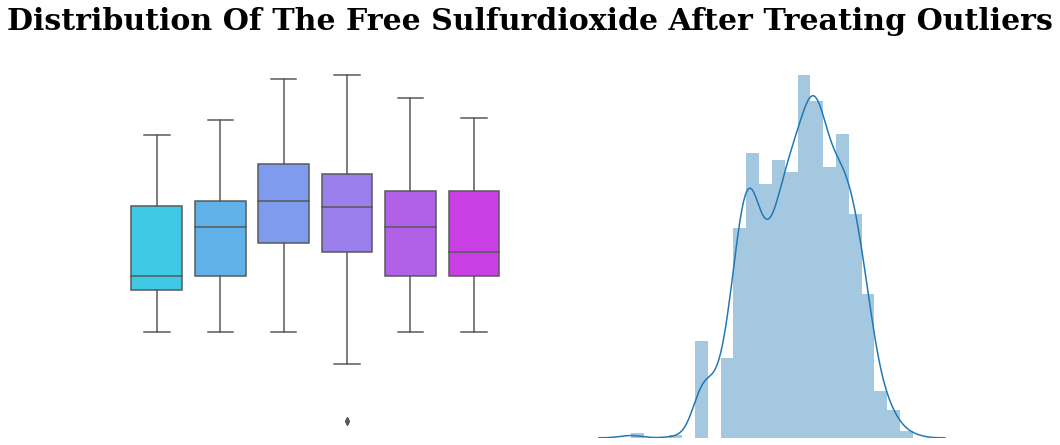

In [33]:
df["Log_free sulfur dioxide"]=np.log(df["free sulfur dioxide"])

plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('Distribution Of The Free Sulfurdioxide After Treating Outliers', fontsize=30, fontweight='bold')

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x=df["quality"], y=df["Log_free sulfur dioxide"],palette="cool")
plt.axis('off')

ax2 = fig.add_subplot(122)
x=df["Log_free sulfur dioxide"]
ax2 = sns.distplot(x)
plt.axis('off')
plt.show()

Text(0.5, 0.98, 'Distribution Of The Total Sulfurdioxide Before Treating Oultier')

(-0.5, 5.5, -8.15, 303.15)

(-34.19550720770688, 329.19550720770684, 0.0, 0.02001731682774437)

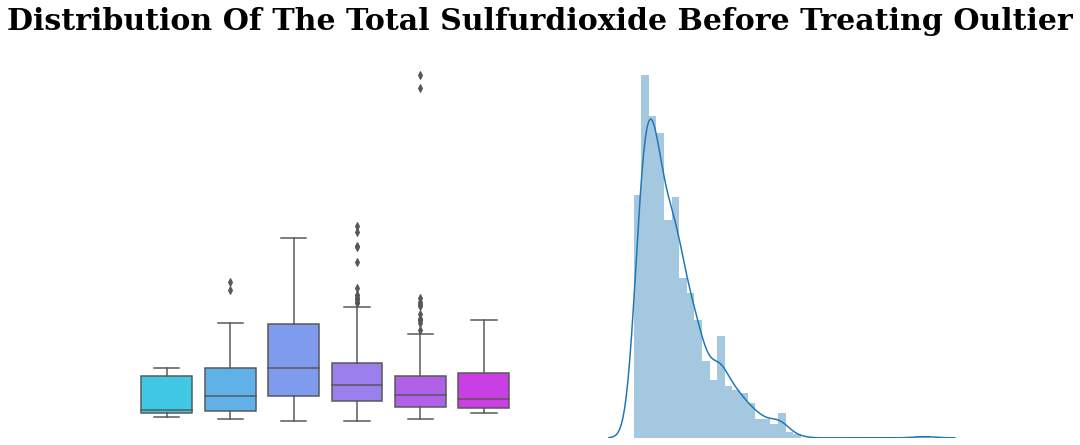

In [34]:
plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('Distribution Of The Total Sulfurdioxide Before Treating Oultier', fontsize=30, fontweight='bold')

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x=df["quality"], y=df["total sulfur dioxide"],palette="cool")
plt.axis('off')

ax2 = fig.add_subplot(122)
x=df["total sulfur dioxide"]
ax2 = sns.distplot(x)
plt.axis('off')
plt.show()

Text(0.5, 0.98, 'Distribution Of The Total Sulfurdioxide After Treating Outliers')

(-0.5, 5.5, 1.598193359375, 5.861767578125)

(1.043557821930183, 6.416403115569818, 0.0, 0.5734935818821028)

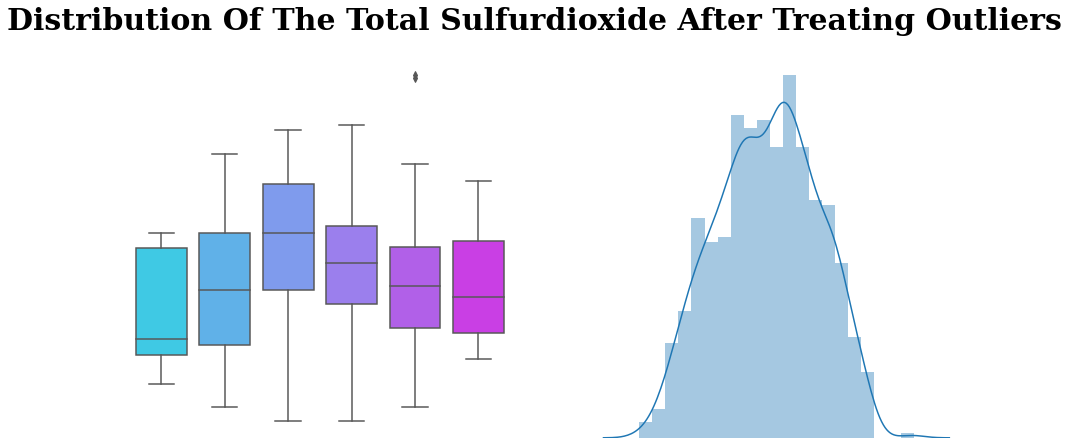

In [35]:
df["Log_total sulfur dioxide"]=np.log(df["total sulfur dioxide"])

plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('Distribution Of The Total Sulfurdioxide After Treating Outliers', fontsize=30, fontweight='bold')

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x=df["quality"], y=df["Log_total sulfur dioxide"],palette="cool")
plt.axis('off')

ax2 = fig.add_subplot(122)
x=df["Log_total sulfur dioxide"]
ax2 = sns.distplot(x)
plt.axis('off')
plt.show()

Text(0.5, 0.98, 'Distribution Of The Density')

(-0.5, 5.5, 0.98955078125, 1.00458984375)

(0.9880945994467043, 1.0060460255532957, 0.0, 309.2344370860927)

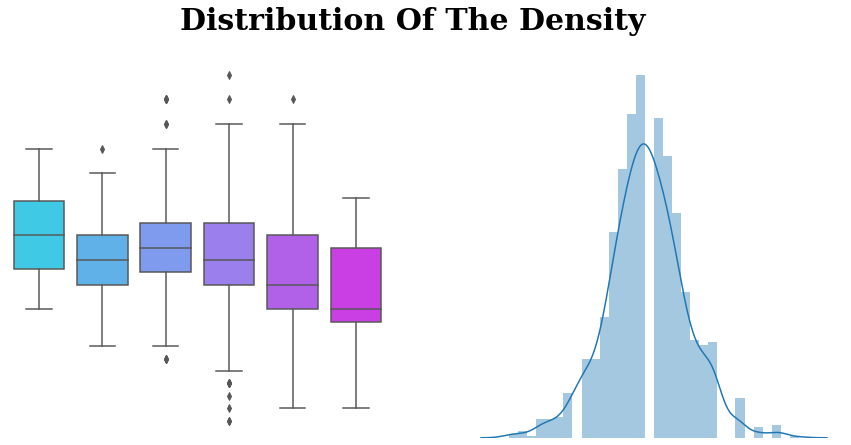

In [36]:
plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('Distribution Of The Density', fontsize=30, fontweight='bold')

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x=df["quality"], y=df["density"],palette="cool")
plt.axis('off')

ax2 = fig.add_subplot(122)
x=df["density"]
ax2 = sns.distplot(x)
plt.axis('off')
plt.show()

Text(0.5, 0.98, 'Distribution Of The pH')

(-0.5, 5.5, 2.67666015625, 4.07529296875)

(2.555787788973064, 4.196165336026937, 0.0, 3.4174654038785377)

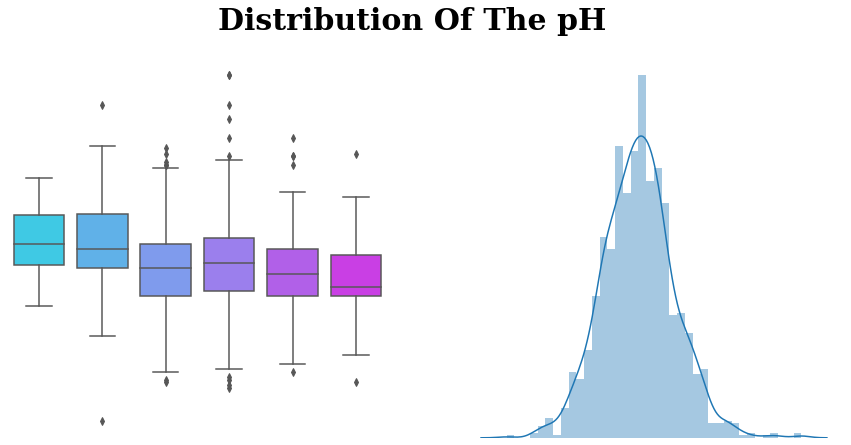

In [37]:
plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('Distribution Of The pH', fontsize=30, fontweight='bold')

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x=df["quality"], y=df["pH"],palette="cool")
plt.axis('off')

ax2 = fig.add_subplot(122)
x=df["pH"]
ax2 = sns.distplot(x)
plt.axis('off')
plt.show()

Text(0.5, 0.98, 'Distribution Of The Sulphates Before Treating Oultier')

(-0.5, 5.5, 0.24658203125, 2.08349609375)

(0.11351964524297598, 2.216558479757024, 0.0, 4.418522391335227)

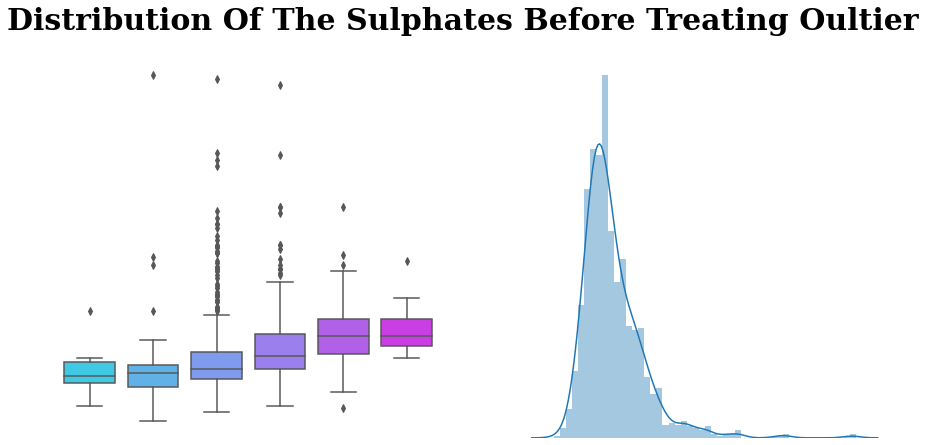

In [38]:
plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('Distribution Of The Sulphates Before Treating Oultier', fontsize=30, fontweight='bold')

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x=df["quality"], y=df["sulphates"],palette="cool")
plt.axis('off')

ax2 = fig.add_subplot(122)
x=df["sulphates"]
ax2 = sns.distplot(x)
plt.axis('off')
plt.show()

Text(0.5, 0.98, 'Distribution Of The Sulphates After Treating Outliers')

(-0.5, 5.5, -1.198486328125, 0.783447265625)

(-1.3733018274753397, 0.9582627649753397, 0.0, 2.4391191514564152)

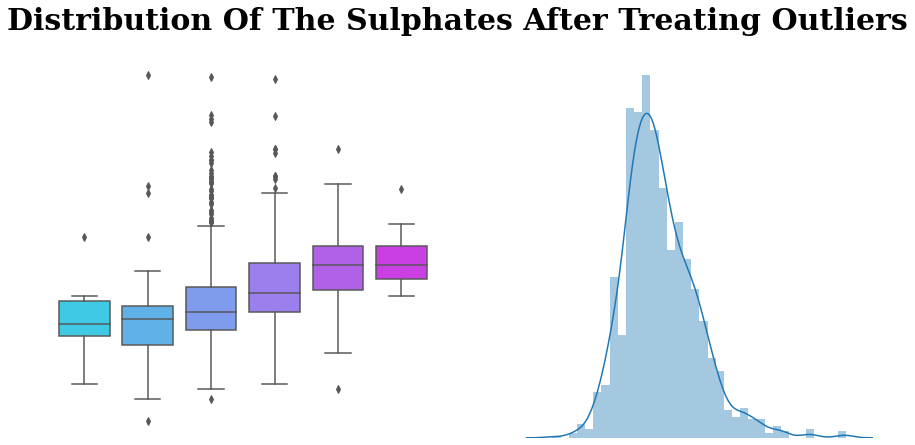

In [39]:
df["Log_sulphates"]=np.log(df["sulphates"])

plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('Distribution Of The Sulphates After Treating Outliers', fontsize=30, fontweight='bold')

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x=df["quality"], y=df["Log_sulphates"],palette="cool")
plt.axis('off')

ax2 = fig.add_subplot(122)
x=df["Log_sulphates"]
ax2 = sns.distplot(x)
plt.axis('off')
plt.show()

Text(0.5, 0.98, 'Distribution Of The Alcohol Before Treating Oultier')

(-0.5, 5.5, 8.0734375, 15.2234375)

(7.229940068696215, 16.066934931303784, 0.0, 0.7080828663610123)

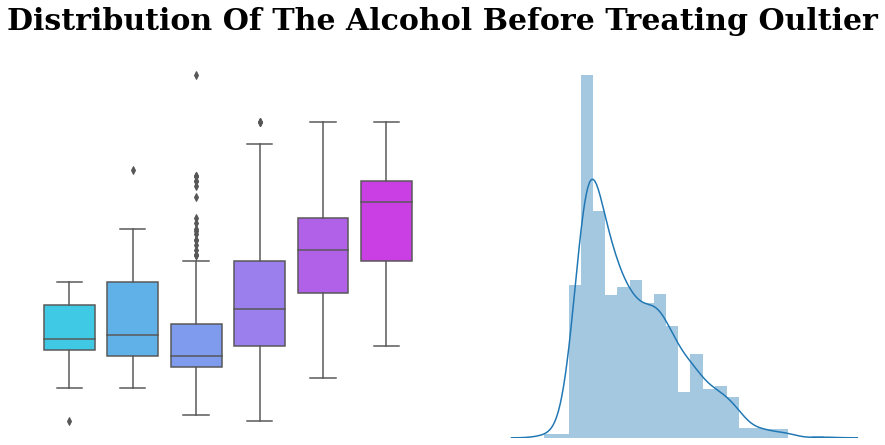

In [40]:
plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('Distribution Of The Alcohol Before Treating Oultier', fontsize=30, fontweight='bold')

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x=df["quality"], y=df["alcohol"],palette="cool")
plt.axis('off')

ax2 = fig.add_subplot(122)
x=df["alcohol"]
ax2 = sns.distplot(x)
plt.axis('off')
plt.show()

Text(0.5, 0.98, 'Distribution Of The Alcohol After Treating Outliers')

(-0.5, 5.5, 2.10029296875, 2.72978515625)

(2.022151963922929, 2.807926161077071, 0.0, 7.201536966299748)

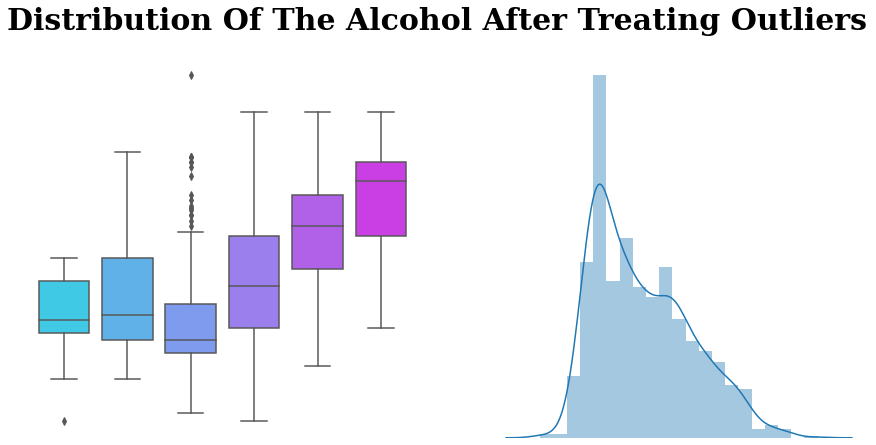

In [41]:
df["Log_alcohol"]=np.log(df["alcohol"])
plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('Distribution Of The Alcohol After Treating Outliers', fontsize=30, fontweight='bold')

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x=df["quality"], y=df["Log_alcohol"],palette="cool")
plt.axis('off')

ax2 = fig.add_subplot(122)
x=df["Log_alcohol"]
ax2 = sns.distplot(x)
plt.axis('off')
plt.show()

Text(0.5, 0.98, 'Before-Distribution Of The Quality')

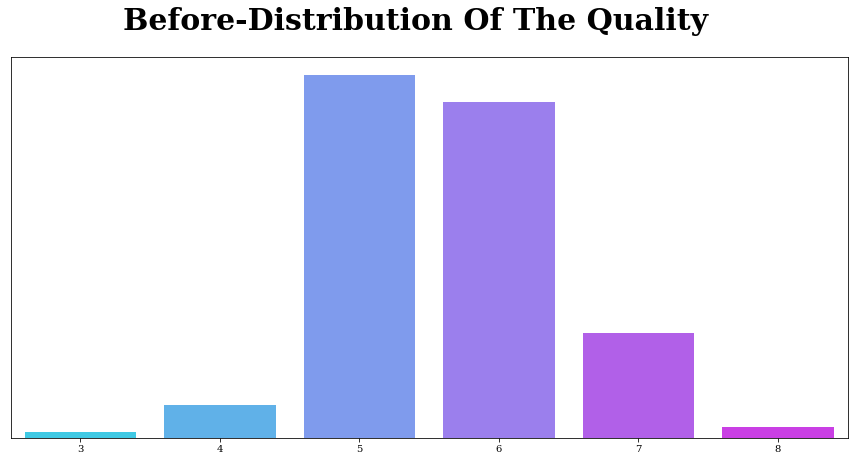

In [42]:
plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('Before-Distribution Of The Quality', fontsize=30, fontweight='bold')
ax = sns.barplot(y = df['quality'].value_counts().values.tolist(), 
                      x = df['quality'].value_counts().index, palette="cool")
ax.get_yaxis().set_visible(False)
plt.show()

In [43]:
bins = (2, 6.5, 8)
group_names = ['bad', 'good']
df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)

df['quality'].replace({'bad':0, 'good':1}, inplace=True)

Text(0.5, 0.98, 'After-Distribution Of The Quality')

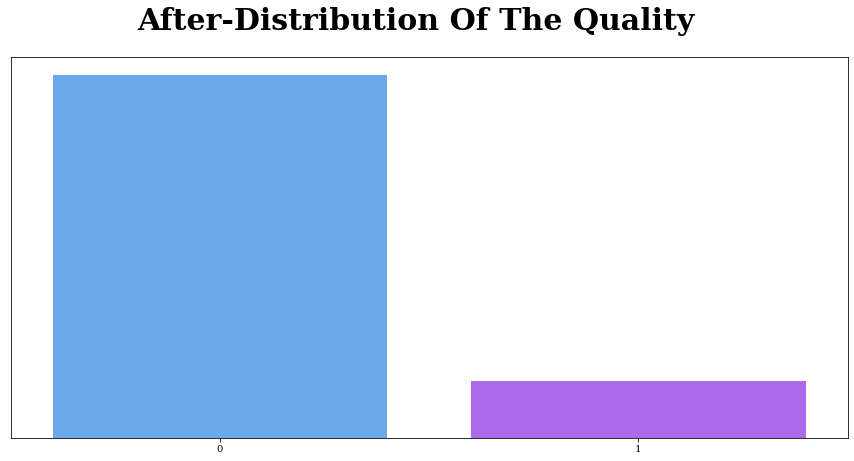

In [44]:
plt.rcParams['font.family'] = ['serif']
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
fig.suptitle('After-Distribution Of The Quality', fontsize=30, fontweight='bold')

ax = sns.barplot(y = df['quality'].value_counts().values.tolist(), 
                      x = df['quality'].value_counts().index, palette="cool")
ax.get_yaxis().set_visible(False)
plt.show()

In [45]:
df.drop(columns = ['fixed acidity', 'volatile acidity','residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide','sulphates', 'alcohol'],axis=True,inplace =True)

In [46]:
df = df[['Log_fixed acidity','Log_volatile acidity','citric acid', 'Log_residual sugar', 'Log_chlorides',
       'Log_free sulfur dioxide', 'Log_total sulfur dioxide','density',
       'pH','Log_sulphates','Log_alcohol','quality']]

In [47]:
df.head().style.background_gradient(cmap='cool')

,Log_fixed acidity,Log_volatile acidity,citric acid,Log_residual sugar,Log_chlorides,Log_free sulfur dioxide,Log_total sulfur dioxide,density,pH,Log_sulphates,Log_alcohol,quality
0,2.001953,-0.356445,0.000000,0.642090,-2.578125,2.398438,3.525391,0.997559,3.509766,-0.579590,2.240234,0
1,2.054688,-0.127930,0.000000,0.955566,-2.322266,3.218750,4.203125,0.996582,3.199219,-0.385498,2.281250,0
2,2.054688,-0.274658,0.040009,0.833008,-2.386719,2.708984,3.988281,0.997070,3.259766,-0.430908,2.281250,0
3,2.416016,-1.272461,0.560059,0.642090,-2.589844,2.833984,4.093750,0.998047,3.160156,-0.544434,2.281250,0
5,2.001953,-0.415283,0.000000,0.587891,-2.589844,2.564453,3.689453,0.997559,3.509766,-0.579590,2.240234,0


<Figure size 1080x504 with 0 Axes>

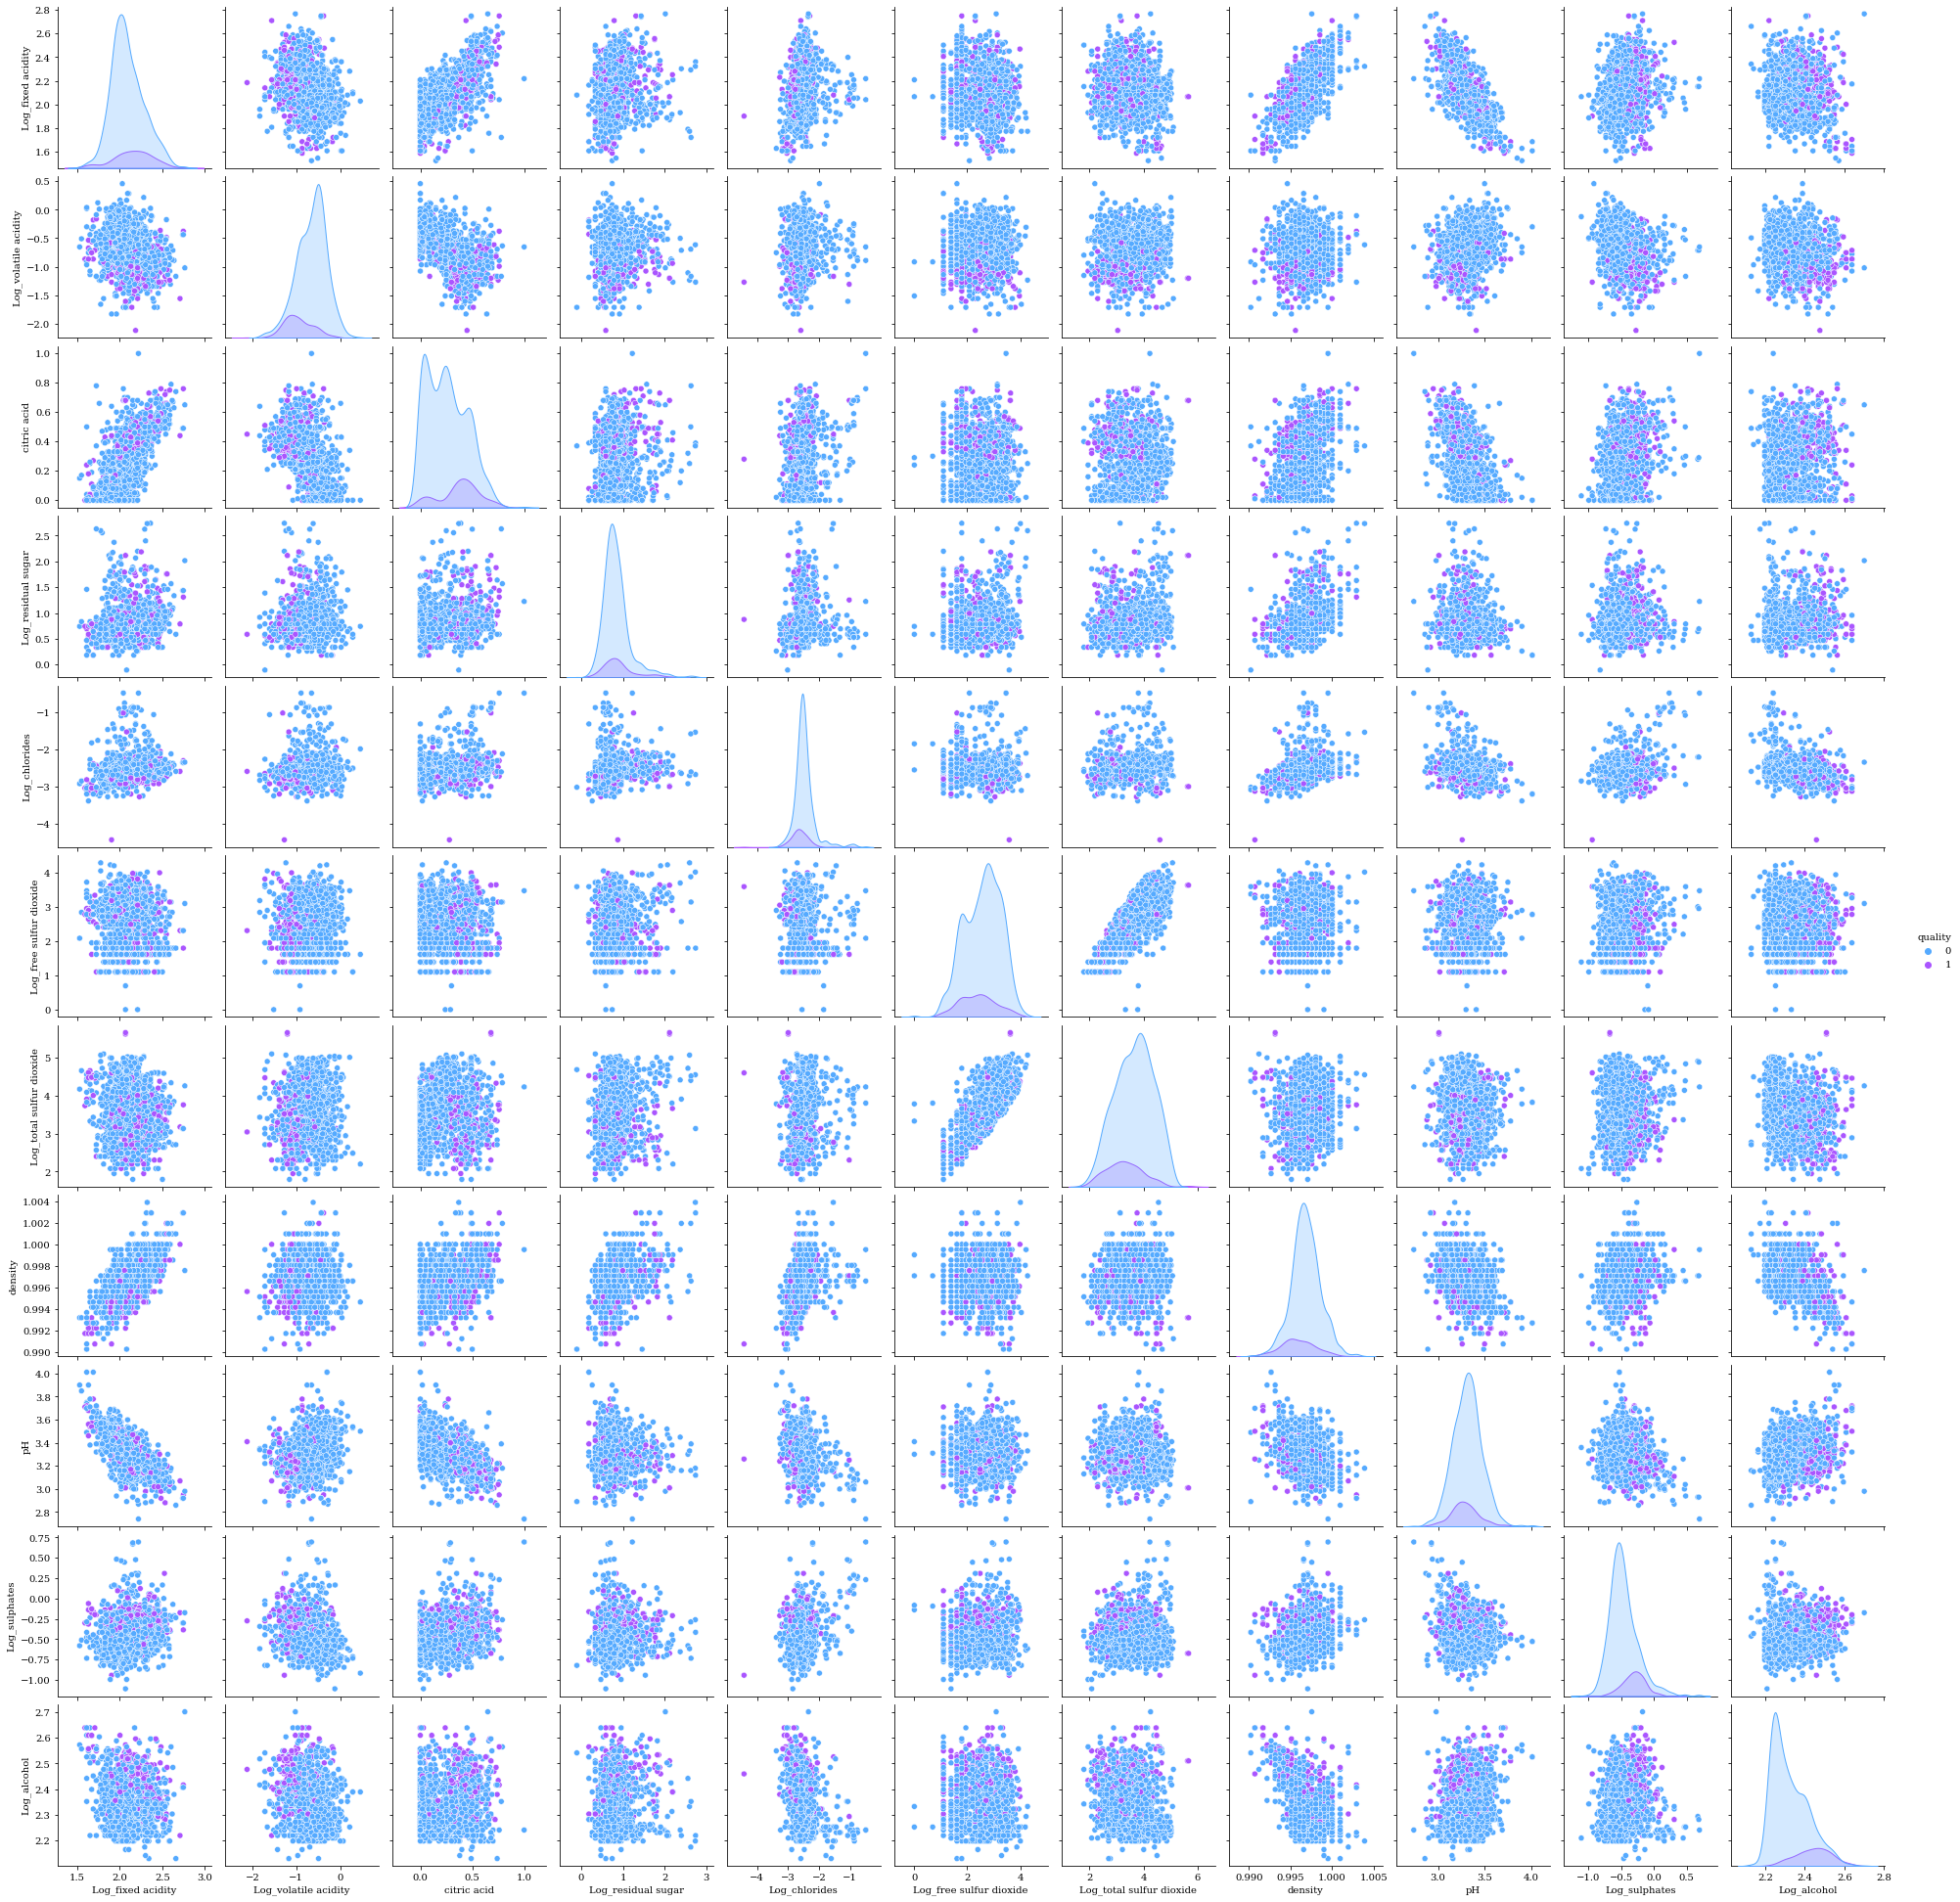

In [48]:
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
sns.pairplot(df,hue='quality',palette="cool")

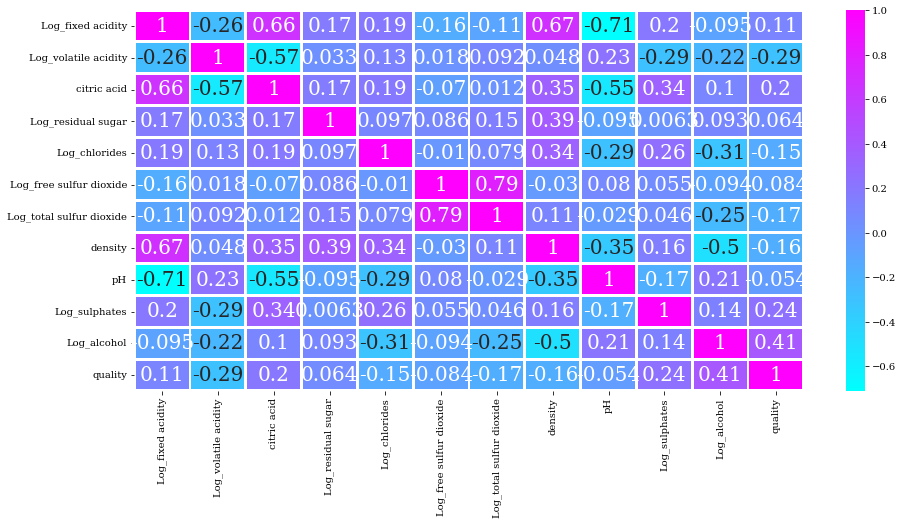

In [49]:
background_color = "#ffffff"
fig = plt.figure(figsize=(15,7), facecolor=background_color)
sns.heatmap(df.corr(), annot=True,cmap = "cool",linewidths=2,linecolor = "white",cbar=True,annot_kws={"size":20})

Text(-1.1, 1.25, 'Correlation of Numerical Features with Target')

Text(0, 0.5, '')

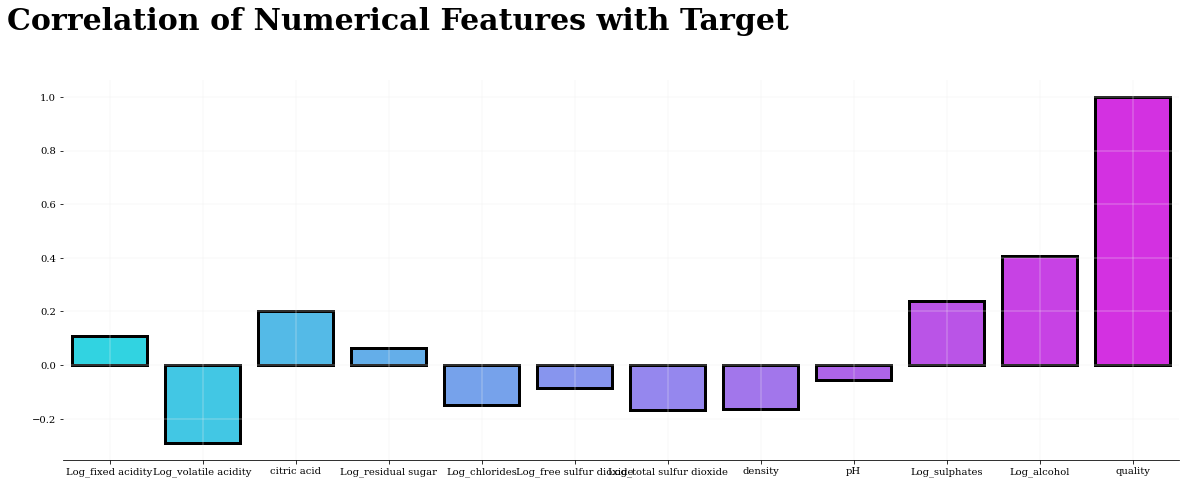

In [50]:
background_color = "#ffffff"
fig = plt.figure(figsize=(20,7), facecolor=background_color)
gs = fig.add_gridspec(1, 1)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)
ax0.text(-1.1, 1.25, 'Correlation of Numerical Features with Target', fontsize=30, fontweight='bold')

chart_df = pd.DataFrame(df.corrwith(df['quality']))
chart_df.columns = ['corr']
sns.barplot(x=chart_df.index, y=chart_df['corr'], ax=ax0, palette='cool',edgecolor="black",linewidth=3)
ax0.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
ax0.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
ax0.set_ylabel('')

for s in ["top","right", 'left']:
    ax0.spines[s].set_visible(False)

plt.show()

In [51]:
x = df.drop('quality',axis=1)

Y = df['quality']

x_train,x_test,Y_train,Y_test = train_test_split(x,Y,test_size = 0.25,random_state=44)

In [52]:

pca = PCA(n_components = None)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
explained_variance = pca.explained_variance_ratio_

print(explained_variance)

[5.85641653e-01 1.08642263e-01 9.85154543e-02 7.64769047e-02
 6.04299870e-02 2.88552593e-02 2.50095490e-02 7.60944592e-03
 4.80496701e-03 4.01420425e-03 3.12261229e-07]


In [53]:
len(explained_variance)

11

In [54]:
print("Sorted List returned :")
print(sorted(explained_variance,reverse = True))

Sorted List returned :
[0.585641653282363, 0.10864226287909248, 0.0985154542965524, 0.07647690474821398, 0.060429987049744505, 0.02885525932797049, 0.025009548971263566, 0.007609445922171313, 0.004804967010158163, 0.004014204251241397, 3.1226122865626723e-07]


<BarContainer object of 11 artists>

Text(0, 0.5, 'Explained Variance Ratio')

Text(0.5, 0, 'Principal Components')

Text(0.5, 1.0, 'Explained Variance Ration vs Principal Components')

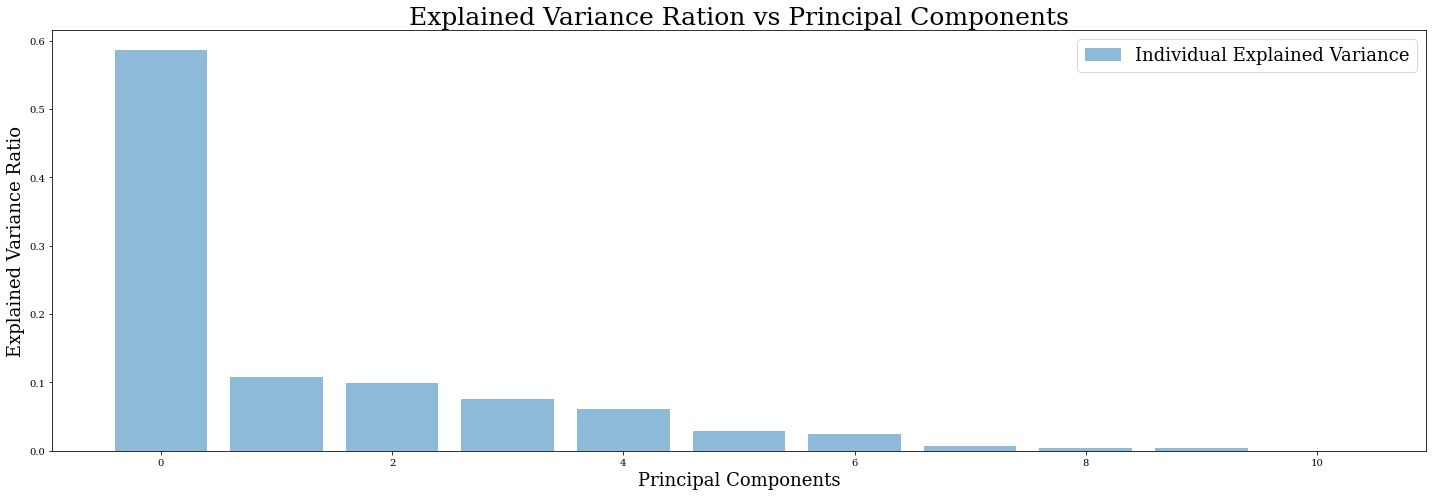

In [55]:
background_color = "#ffffff"
fig = plt.figure(figsize=(20,7), facecolor=background_color)
plt.bar(range(11), explained_variance, alpha=0.5, align='center',label='Individual Explained Variance')
plt.ylabel('Explained Variance Ratio',fontsize = 18)
plt.xlabel('Principal Components',fontsize = 18)
plt.title('Explained Variance Ration vs Principal Components',fontsize = 25)
plt.legend(loc='best',fontsize = 18)

plt.tight_layout()
plt.show()

In [56]:

from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[0.58564165 0.10864226 0.09851545 0.0764769  0.06042999]


Text(0.5, 0, 'Mean Accuracy')

<Figure size 1080x504 with 0 Axes>

   CrossVal_Score_Means  CrossValerrors                    Algo
0              0.833177        0.012775  RandomForestClassifier
1              0.851801        0.011581      AdaBoostClassifier
2              0.853754        0.013817       Gradient Boosting
3              0.823350        0.018824  DecisionTreeClassifier


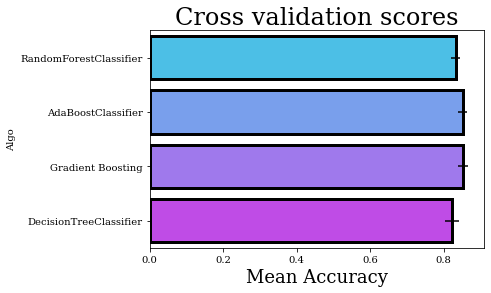

<Figure size 1080x504 with 0 Axes>

In [57]:

kfold = StratifiedKFold(n_splits=8,shuffle=True, random_state=42)


rs = 15
clrs = []

clrs.append(AdaBoostClassifier(random_state=rs))
clrs.append(GradientBoostingClassifier(random_state=rs))
clrs.append(RandomForestClassifier(random_state=rs))
clrs.append(DecisionTreeClassifier(random_state = rs))

cv_results = []
for clr in clrs :
    cv_results.append(cross_val_score(clr, x_train, Y_train , scoring = 'accuracy', cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_df = pd.DataFrame({"CrossVal_Score_Means":cv_means,"CrossValerrors": cv_std,"Algo":["RandomForestClassifier","AdaBoostClassifier","Gradient Boosting",'DecisionTreeClassifier']})
g = sns.barplot("CrossVal_Score_Means","Algo",data = cv_df,orient = "h",**{'xerr':cv_std},palette='cool',edgecolor="black",linewidth=3)
g.set_xlabel("Mean Accuracy",fontsize = 18)
g = g.set_title("Cross validation scores",fontsize = 24)
plt.figure(figsize = (15,7))
print(cv_df)

In [58]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train, Y_train)
Y_pred = dtc.predict(x_test)
confusion_matrix(Y_test, Y_pred)

DecisionTreeClassifier()

array([[256,  37],
       [ 31,  16]])

In [59]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       293
           1       0.30      0.34      0.32        47

    accuracy                           0.80       340
   macro avg       0.60      0.61      0.60       340
weighted avg       0.81      0.80      0.80       340



In [60]:
print(accuracy_score(Y_test, Y_pred))

0.8


In [61]:
from sklearn.model_selection import GridSearchCV
grid_params = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 5, 7, 10],
    'min_samples_split' : range(2, 10, 1),
    'min_samples_leaf' : range(2, 10, 1)
}

grid_search = GridSearchCV(dtc, grid_params, cv = 5, n_jobs = -1, verbose = 1)
grid_search.fit(x_train, Y_train)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': range(2, 10),
                         'min_samples_split': range(2, 10)},
             verbose=1)

In [62]:
dtc = grid_search.best_estimator_
Y_pred = dtc.predict(x_test)  

In [63]:
print(accuracy_score(Y_test, Y_pred))

0.8676470588235294


In [64]:

print(grid_search.best_params_)
print(grid_search.best_score_)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 2}
0.8577127402685212


In [65]:
ada = AdaBoostClassifier(base_estimator = dtc)

parameters = {
    'n_estimators' : [50, 70, 90, 120, 180, 200],
    'learning_rate' : [0.001, 0.01, 0.1, 1, 10],
    'algorithm' : ['SAMME', 'SAMME.R']
}

grid_search = GridSearchCV(ada, parameters, n_jobs = -1, cv = 10, verbose = 1)
grid_search.fit(x_train, Y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


GridSearchCV(cv=10,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                max_depth=5,
                                                                                min_samples_leaf=8)),
             n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.001, 0.01, 0.1, 1, 10],
                         'n_estimators': [50, 70, 90, 120, 180, 200]},
             verbose=1)

In [66]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'algorithm': 'SAMME', 'learning_rate': 0.001, 'n_estimators': 200}
0.8635993011065812


In [67]:
ada = AdaBoostClassifier(base_estimator = dtc, algorithm= "SAMME", learning_rate= 0.1, n_estimators= 90)
ada.fit(x_train, Y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=5,
                                                         min_samples_leaf=8),
                   learning_rate=0.1, n_estimators=90)

In [68]:
print(confusion_matrix(Y_test, Y_pred))

[[281  12]
 [ 33  14]]


In [69]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       293
           1       0.54      0.30      0.38        47

    accuracy                           0.87       340
   macro avg       0.72      0.63      0.65       340
weighted avg       0.85      0.87      0.85       340



In [70]:
print(accuracy_score(Y_test, Y_pred))

0.8676470588235294
